Before I could go on to make my tool for a week by week and day by day breakdown of the scriptures, I remembered the approaching October 2024 Seminannual Conference of the Church of the Jesus Christ of Latter-day Saints (dated for October 5th and 6th, 2024). I realized that if I could develop a tool for breaking down those talks into daily chunks using dates and such, then I could build on that work when making my Come, Follow Me breakdown tool. 

In order to start that whole endeavor, I needed to, once again, do some webscraping - this time to get the lengths of the talks from the most recent (April 2024) General Conference. 

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import os
import time
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import re
import glob
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager

In [2]:
os.getcwd()

'd:\\Faith and Religion Stuff\\Come, Follow Me\\come-follow-me-breakdown-builder'

I started by navigating to the Church's website to get the link to the landing page for the April 2024 General Conference. 

In [3]:
apr_2024_gc_link = 'https://www.churchofjesuschrist.org/study/general-conference/2024/04?lang=eng'

From there, I took a look at the html code that holds the page up to see what objects I needed to get the links for. 

In [4]:
response = requests.get(apr_2024_gc_link)
response

<Response [200]>

A 200 response means that my information requester is working and getting data. 

In [9]:
soup = BeautifulSoup(response.content, "html.parser")
content = soup.prettify()  # This formats the HTML in a (more) readable way
print(content)

<!DOCTYPE html>
<html lang="en">
 <head>
  <meta charset="utf-8"/>
  <title data-react-helmet="true">
   April 2024 general conference
  </title>
  <meta content="4.20.0" name="version"/>
  <meta content="width=device-width, initial-scale=1, minimum-scale=1" name="viewport"/>
  <meta content="" data-react-helmet="true" name="Search.doc-aid">
   <meta content="April 2024 general conference" data-react-helmet="true" name="title">
    <meta content="April 2024 general conference" data-react-helmet="true" name="description">
     <meta content="April 2024 general conference" data-react-helmet="true" property="og:title"/>
     <meta content="website" data-react-helmet="true" property="og:type"/>
     <meta content="https://www.churchofjesuschrist.org/study/eng/general-conference/2024/04/_manifest" data-react-helmet="true" property="og:url"/>
     <link as="script" href="https://www.churchofjesuschrist.org/services/platform/v4/index.js" rel="preload"/>
     <link href="https://foundry.church

Unfortunately, it seems like for this case, all sections of the page (Saturday Morning Session, Sustaining, Church Audit Report, and the talks) are all formatted using the same class and object names - **class="sc-omeqik-0 ewktus list-tile listTile-WHLxI"**. This will be my CSS_Selector, as this is the "heading" to each of the different html objects. I'll be using that class object to get the authors of each talk, the titles, the descriptions, and the links. Using that information, I'll be able to:
* Clean the created dataframe by deleting things like the sustaining, auditing report, and the links to the entire session videos
* Get the number of paragraphs and lines for each paragraph for each talk
* Export that data to my device for using to test and develop my daily reading breakdown tool. 

I need to start by getting that information. I'll start by just copying and pasting the code that I used previously to get links to chapters of the scriptures. I then adapted the code to look for the authors, titles, descriptions, and links to each of the videos linked on that Conference's landing page. Notes in the code itself explain what is happening with every vital line of code.  

In [12]:
# Define the path to the chromedriver executable
chrome_driver_dir = r'D:\\Faith and Religion Stuff\\Come, Follow Me\\chromedriver-win64'
chrome_driver_path = os.path.join(chrome_driver_dir, 'chromedriver.exe')

 # Set up the headless browser options
chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--disable-gpu")
chrome_options.add_argument("--window-size=1920x1080")

# Set up the Chrome service
service = Service(chrome_driver_path)    
    
# Initialize the Chrome WebDriver
driver = webdriver.Chrome(service=service, options=chrome_options)

# Establish a try loop that tries to navigate to the provided link and find and store bits of info that we need 
try:
    # Navigate to the page with your elements - in this case the April 2024 General Conference
    driver.get(apr_2024_gc_link)

    # Find all elements with the specified class name
    # Gotta use dots, not spaces, here because CSS considers each of those spaces to be defining a dif class object
    elements = driver.find_elements(By.CSS_SELECTOR, 'a.sc-omeqik-0.ewktus.list-tile.listTile-WHLxI')  

    # Initialize a list to store authors, titles, descriptions, and links
    primary_meta_list = []
    title_list = []
    description_list = []
    href_list = []
    

    # Iterate over each element
    # This for loop will, for all the videos/links to talks on the 2024 General Conference page, run through each of the following operations before moving onto the next
    for element in elements:
        # Try to get the author
        try:
            # Finds and stores the primary meta element (which is the author of the talk or report)
            primary_meta_element = element.find_element(By.CSS_SELECTOR,'p.primaryMeta')
            # Saves the stored author information as text
            primary_meta = primary_meta_element.text
        # If there is no author, save the author as None or Null
        except:
            primary_meta = None
        # Adds the author (or the None) to the list of authors in the appropriate row
        primary_meta_list.append(primary_meta)

        # Try to get the title - every link/video should have a title
        try:
            # Finds and stores the title element (the title of the video, talk, or report)
            title_element = element.find_element(By.CSS_SELECTOR,'p.title')
            # Saves the stored title as text
            title = title_element.text
        # If there is no title, save the title as None - THIS SHOULD NEVER BE THE CASE
        except:
            title = None
        # add the title (or the None) to the list of titles in the appropriate row
        title_list.append(title)

        # Try to get the description - the summary blurb about the video, talk, or report
        try:
            # Finds and stores the description element (the title of the video, talk, or report)
            description_element = element.find_element(By.CSS_SELECTOR,'p.description')
            # Saves the stored description as text
            description = description_element.text
        # If there is no description, save it as None - THIS SHOULD NEVER BE THE CASE
        except:
            description = None
        # add the title (or the None) to the list of descriptions in the appropriate row
        description_list.append(description)

        # Finds and stores the link (or href) to the video, talk, or report
        # This is ultimately going to be the information we use later to get the lengths (in paragraphs) of the talks and the lengths (in lines) of each of those paragraphs
        href = element.get_attribute('href')
        # Adds the stored href to the list of hrefs in the appropriate row
        href_list.append(href)

    # Creates a dataframe to store all the found and stored lists together
    apr_2024_df = pd.DataFrame({
        'Author': primary_meta_list,
        'Title': title_list,
        'Description': description_list,
        'Link': href_list
    })

# If anything doesn't work for some reason, tell why
except Exception as e:
    print(f"An error occurred: {e}")

# After running everything, close the driver we opened to collect the data
finally:
    # Close the browser
    driver.quit()

The cell below, when run after the cell above, demonstrates that the data was collected and saved ***exactly*** the way I wanted it to be. It also shows that there are 39 videos linked to on that landing page. Of these videos:
* 5 are links to watch an entire session.
* 1 is a link to watch the Sustaining of General Authorities 
* 1 is a link to watch the Auditing Report
* The remaining 32 are actual General Conference talks. Everything besides these will be deleted. 

In [13]:
apr_2024_df

,Author,Title,Description,Link
0,None,Saturday Morning Session,The Saturday Morning Session of the 194th Annu...,https://www.churchofjesuschrist.org/study/gene...
1,Dallin H. Oaks,"Sustaining of General Authorities, Area Sevent...","President Oaks presents General Authorities, A...",https://www.churchofjesuschrist.org/study/gene...
2,Jared B. Larson,"Church Auditing Department Report, 2023",Jared B. Larson reads the Church auditing report.,https://www.churchofjesuschrist.org/study/gene...
3,Jeffrey R. Holland,Motions of a Hidden Fire,President Holland teaches about the power of p...,https://www.churchofjesuschrist.org/study/gene...
4,J. Anette Dennis,Put Ye On the Lord Jesus Christ,"Sister Dennis teaches about the importance, po...",https://www.churchofjesuschrist.org/study/gene...
5,Alexander Dushku,Pillars and Rays,Elder Dushku teaches us that spectacular spiri...,https://www.churchofjesuschrist.org/study/gene...
6,Ulisses Soares,Covenant Confidence through Jesus Christ,Elder Soares teaches about the importance of l...,https://www.churchofjesuschrist.org/study/gene...
7,Jack N. Gerard,Integrity: A Christlike Attribute,Elder Gerard teaches that living a life of int...,https://www.churchofjesuschrist.org/study/gene...
8,Henry B. Eyring,All Will Be Well Because of Temple Covenants,President Eyring teaches that as we make and k...,https://www.churchofjesuschrist.org/study/gene...
9,None,Saturday Afternoon Session,The Saturday Afternoon Session of the 194th An...,https://www.churchofjesuschrist.org/study/gene...


Before proceeding with getting the lengths of the talks and their lines, I need to delete the objects from this dataframe that don't need to be there. These are:
* line 0 - Saturday Morning Session
* line 1 - Sustaining
* line 2 - Audit Report
* line 9 - Saturday Afternoon Session
* line 17 - Saturday Evening Session
* line 23 - Sunday Morning Session
* line 31 - Sunday Afternoon Session

In [14]:
# Removes lines 0 - 2
apr_2024_df = apr_2024_df[3:]

# establishes other lines to remove
lines = [9,17,23,31]
# removes those lines
apr_2024_df = apr_2024_df.drop(lines)

# Displays the updated dataframe
apr_2024_df

,Author,Title,Description,Link
3,Jeffrey R. Holland,Motions of a Hidden Fire,President Holland teaches about the power of p...,https://www.churchofjesuschrist.org/study/gene...
4,J. Anette Dennis,Put Ye On the Lord Jesus Christ,"Sister Dennis teaches about the importance, po...",https://www.churchofjesuschrist.org/study/gene...
5,Alexander Dushku,Pillars and Rays,Elder Dushku teaches us that spectacular spiri...,https://www.churchofjesuschrist.org/study/gene...
6,Ulisses Soares,Covenant Confidence through Jesus Christ,Elder Soares teaches about the importance of l...,https://www.churchofjesuschrist.org/study/gene...
7,Jack N. Gerard,Integrity: A Christlike Attribute,Elder Gerard teaches that living a life of int...,https://www.churchofjesuschrist.org/study/gene...
8,Henry B. Eyring,All Will Be Well Because of Temple Covenants,President Eyring teaches that as we make and k...,https://www.churchofjesuschrist.org/study/gene...
10,David A. Bednar,"“Be Still, and Know That I Am God”","Elder Bednar teaches that when we are “still,”...",https://www.churchofjesuschrist.org/study/gene...
11,Massimo De Feo,Rise! He Calleth Thee,Elder De Feo teaches that blessings come when ...,https://www.churchofjesuschrist.org/study/gene...
12,Brent H. Nielson,A Record of What I Have Both Seen and Heard,Elder Nielson describes the growth of the Chur...,https://www.churchofjesuschrist.org/study/gene...
13,Jose L. Alonso,Jesus Christ at the Center of Our Lives,Elder Alonso testifies that as we place Jesus ...,https://www.churchofjesuschrist.org/study/gene...


I ran the cell below to ensure that the code that collected all this information would work on other conferences. 

In [9]:
# saves the link to the October 2023 General Conference landing page
oct_2023_gc_link = 'https://www.churchofjesuschrist.org/study/general-conference/2023/10?lang=eng'

# Define the path to the chromedriver executable
chrome_driver_dir = r'D:\\Faith and Religion Stuff\\Come, Follow Me\\chromedriver-win64'
chrome_driver_path = os.path.join(chrome_driver_dir, 'chromedriver.exe')

 # Set up the headless browser options
chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--disable-gpu")
chrome_options.add_argument("--window-size=1920x1080")

# Set up the Chrome service
service = Service(chrome_driver_path)    
    
# Initialize the Chrome WebDriver
driver = webdriver.Chrome(service=service, options=chrome_options)

# Establish a try loop that tries to navigate to the provided link and find and store bits of info that we need 
try:
    # Navigate to the page with your elements - in this case the October 2023 General Conference
    driver.get(oct_2023_gc_link)

    # Find all elements with the specified class name
    # Gotta use dots, not spaces, here because CSS considers each of those spaces to be defining a dif class object
    elements = driver.find_elements(By.CSS_SELECTOR, 'a.sc-omeqik-0.ewktus.list-tile.listTile-WHLxI')  

    # Initialize a list to store authors, titles, descriptions, and links
    primary_meta_list = []
    title_list = []
    description_list = []
    href_list = []
    

    # Iterate over each element
    # This for loop will, for all the videos/links to talks on the 2024 General Conference page, run through each of the following operations before moving onto the next
    for element in elements:
        # Try to get the author
        try:
            # Finds and stores the primary meta element (which is the author of the talk or report)
            primary_meta_element = element.find_element(By.CSS_SELECTOR,'p.primaryMeta')
            # Saves the stored author information as text
            primary_meta = primary_meta_element.text
        # If there is no author, save the author as None or Null
        except:
            primary_meta = None
        # Adds the author (or the None) to the list of authors in the appropriate row
        primary_meta_list.append(primary_meta)

        # Try to get the title - every link/video should have a title
        try:
            # Finds and stores the title element (the title of the video, talk, or report)
            title_element = element.find_element(By.CSS_SELECTOR,'p.title')
            # Saves the stored title as text
            title = title_element.text
        # If there is no title, save the title as None - THIS SHOULD NEVER BE THE CASE
        except:
            title = None
        # add the title (or the None) to the list of titles in the appropriate row
        title_list.append(title)

        # Try to get the description - the summary blurb about the video, talk, or report
        try:
            # Finds and stores the description element (the title of the video, talk, or report)
            description_element = element.find_element(By.CSS_SELECTOR,'p.description')
            # Saves the stored description as text
            description = description_element.text
        # If there is no description, save it as None - THIS SHOULD NEVER BE THE CASE
        except:
            description = None
        # add the title (or the None) to the list of descriptions in the appropriate row
        description_list.append(description)

        # Finds and stores the link (or href) to the video, talk, or report
        # This is ultimately going to be the information we use later to get the lengths (in paragraphs) of the talks and the lengths (in lines) of each of those paragraphs
        href = element.get_attribute('href')
        # Adds the stored href to the list of hrefs in the appropriate row
        href_list.append(href)

    # Creates a dataframe to store all the found and stored lists together
    oct_2023_df = pd.DataFrame({
        'Author': primary_meta_list,
        'Title': title_list,
        'Description': description_list,
        'Link': href_list
    })

# If anything doesn't work for some reason, tell why
except Exception as e:
    print(f"An error occurred: {e}")

# After running everything, close the driver we opened to collect the data
finally:
    # Close the browser
    driver.quit()

oct_2023_df

,Author,Title,Description,Link
0,None,Saturday Morning Session,None,https://www.churchofjesuschrist.org/study/gene...
1,David A. Bednar,In the Path of Their Duty,Elder Bednar expresses his gratitude for Churc...,https://www.churchofjesuschrist.org/study/gene...
2,Amy A. Wright,Abide the Day in Christ,Sister Wright teaches that with the help of Je...,https://www.churchofjesuschrist.org/study/gene...
3,Robert M. Daines,"Sir, We Would Like to See Jesus",Elder Daines teaches principles to help us bet...,https://www.churchofjesuschrist.org/study/gene...
4,Carlos A. Godoy,For the Sake of Your Posterity,Elder Godoy asks those who have fallen away or...,https://www.churchofjesuschrist.org/study/gene...
5,D. Todd Christofferson,The Sealing Power,Elder Christofferson teaches that the sealing ...,https://www.churchofjesuschrist.org/study/gene...
6,Ian S. Ardern,Love Thy Neighbour,Elder Ardern teaches that humanitarian efforts...,https://www.churchofjesuschrist.org/study/gene...
7,Dallin H. Oaks,Kingdoms of Glory,President Oaks teaches about the kingdoms of g...,https://www.churchofjesuschrist.org/study/gene...
8,None,Saturday Afternoon Session,None,https://www.churchofjesuschrist.org/study/gene...
9,Henry B. Eyring,"Sustaining of General Authorities, Area Sevent...",President Eyring presents the General Authorit...,https://www.churchofjesuschrist.org/study/gene...


The fact that the October 2023 dataframe displays properly shows that I everything is working as it should. This is excellent. 

I think that going forward I'll have to manually remove the videos I don't want every time, but that took almost no time at all, and was incredibly simple, so it shouldn't be a problem. 

Having gotten all the links I needed and having created the dataframe I wanted, I'm ready to move on to a new task: using regular expressions (RegEx) to create primary key identifiers for these talks. That's a whole project for another day, though. 

Over the next few days I need to: 
* use scraping to automatically gather information about the organization to which the speaker belongs (probably requiring RegEx)
* use RegEx to create some primary key identifiers (using names and organizations) for each of these talks (to make everything compatible with SQL)
* get the lengths of the talks (in paragraphs and minutes) and the lengths of each paragraph (in lines)

### 5 Sep 2024

I've decided to start dating my work, just for the sake of not needing to go back and fix and adjust markdowns like the one above that outline what my next plans are. 

To start the day off, after finishing up my learning about Regular Expressions (Regex), I pulled up the html information for the first talk of the April 2024 General Conference to see what information I'd be looking for with each talk. 

In [16]:
jrh_link = 'https://www.churchofjesuschrist.org/study/general-conference/2024/04/13holland?lang=eng'
response = requests.get(jrh_link)
soup = BeautifulSoup(response.text, 'html.parser')
content = soup.prettify()  # This formats the HTML in a (more) readable way
print(content)

<!DOCTYPE html>
<html lang="en">
 <head>
  <meta charset="utf-8"/>
  <title data-react-helmet="true">
   Motions of a Hidden Fire
  </title>
  <meta content="4.20.0" name="version"/>
  <meta content="width=device-width, initial-scale=1, minimum-scale=1" name="viewport"/>
  <meta content="159161347" data-react-helmet="true" name="Search.doc-aid">
   <meta content="Motions of a Hidden Fire" data-react-helmet="true" name="title">
    <meta content="President Holland teaches about the power of prayer and testifies that God answers every prayer." data-react-helmet="true" name="description">
     <meta content="https://www.churchofjesuschrist.org/imgs/aa8c48c3769ae5cace7d8eb5dfe5fc385846a55d/full/!192%2C/0/default" data-react-helmet="true" property="og:image"/>
     <meta content="Motions of a Hidden Fire" data-react-helmet="true" property="og:title"/>
     <meta content="website" data-react-helmet="true" property="og:type"/>
     <meta content="https://www.churchofjesuschrist.org/study/eng/

It looks like I'll be able to get the longform office or organization to which each speaker belongs by scraping out the `p class="author-role"`, which for Elder Holland is "Acting President of the Quorum of the Twelve Apostles" and for J. Annette Dennis is "First Counselor in the Relief Society General Presidency." That information should be easy to grab, but I'll have to clean it afterwards using Regex unless I can use Regex to grab only what I need. 

Additionally, each paragraph has its `p data-aid="####"` object. Each paragraph also has an `id="p#'` id object, but the body of the talks each starts with `id="p4"`. So I have a few options:
* I can try to grab all the `id=p#` objects after the `<div class="body-block">`, which separates the body of the talk from the title, author, and `p class="kicker"` summary of the talk. 
* I can try to grab all the `p data-aid="####"` objects after and including `id="p4"`.
* I can grab all the `p data-aid="####"` objects and then remove the ones I don't want. 

The first two seem like they'll be the cleaner, though more complicated options. 

However, I'll start by see if/how I can use Regex to grab the `p class="author-role"` information that I want, then go from there. 

### 6 Sep 2024

I wanted to start today off by locating the bit of html code that tells me the length in time of each talk. This is apparently going to be a **much** more difficult process than I anticipated. Dang. After picking through all the html trying to find the audio or the visual, it looks like what I'll have to do is find the `audio preload="metadata" class="sc-a0q09z-1 cQMORe"` and grab the `src="https://..."` link underneath it (for the audio), then navigate to that link to find the length of the audio. 


Well, I thought that would be the case, but after inspecting all of the html code after following such a link, I found that, for some reason, the length of the talk is not displayed anywhere in the code itself. Hm. Time to ask chatgpt for help. 

After spending probably an hour inspecting everything I could on the page, ChatGPT recommended the solution below. If it works, I'll be going through and breaking down what it does piece by piece. 

In [11]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager

# Set up the Chrome WebDriver
driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()))

# Navigate to the URL
url = "https://www.churchofjesuschrist.org/study/general-conference/2024/04/13holland?lang=eng"
driver.get(url)

# Wait for the page to load completely
driver.implicitly_wait(10)  # Adjust the time if needed

# Locate the video or audio element using JavaScript
video_duration = driver.execute_script("""
    let video = document.querySelector('video');
    if (video) {
        return video.duration;
    } else {
        let audio = document.querySelector('audio');
        if (audio) {
            return audio.duration;
        }
    }
    return null;  // No media element found
""")

# Display the duration in seconds
if video_duration:
    print(f"Duration: {video_duration} seconds")
else:
    print("No video or audio element found on the page")

# Close the browser
driver.quit()

No video or audio element found on the page


The above code didn't work because apparently the webdriver-manager no longer automatically downloads with the ChromeDriver, so I need to install it. 

In [12]:
pip install webdriver-manager

Note: you may need to restart the kernel to use updated packages.


Through a lot of trial and error with ChatGPT's help, I was able to put together the right series of commands to get the duration of the video, which is excellent. 

I started by importing the necessary packages from Selenium (including the manager I had to install earlier), and then had to set up the driver, which, so far as I can tell "drives" the jupyter notebook to navigate to the web and do things there. In this case, it navigated to Elder Holland's talk, waited a few seconds for the page to completely load, clicked the play button on the video, waited for the video to fully load, and then inspected the javascript to find the duration of the video in seconds. 

In [13]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
import time

# Set up the Chrome WebDriver
driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()))

# Navigate to the URL
url = "https://www.churchofjesuschrist.org/study/general-conference/2024/04/13holland?lang=eng"
driver.get(url)

# Wait for the page to load completely
driver.implicitly_wait(10)

# Simulate clicking the play button using the class attribute
try:
    # Locate the play button using its class attribute
    play_button = driver.find_element(By.CSS_SELECTOR, "button.sc-1g7hsbc-0.bCKkuP.sc-bvqtyr-3.eKGiZd")
    play_button.click()
    print("Clicked the play button to start the media.")
except:
    print("Play button not found.")

# Wait for the video element to be present in the DOM
try:
    # Wait explicitly for the video to appear in the DOM
    video_element = WebDriverWait(driver, 20).until(
        EC.presence_of_element_located((By.TAG_NAME, 'video'))
    )
    print("Video element found in the DOM.")
except:
    print("No video element found. Trying to find audio...")

    try:
        # Wait for the audio element to be present in the DOM
        audio_element = WebDriverWait(driver, 20).until(
            EC.presence_of_element_located((By.TAG_NAME, 'audio'))
        )
        print("Audio element found in the DOM.")
    except:
        print("No audio element found.")

# Wait for a short period to allow the video to start loading
time.sleep(5)

# Print the page source for debugging
print(driver.page_source)  # Print the current page's HTML to see if the video or audio element is present

# Attempt to retrieve the video duration using JavaScript
try:
    video_duration = driver.execute_script("""
        let video = document.querySelector('video');
        if (video) {
            console.log('Video element is present, checking duration...');
            return video.duration;
        } else {
            let audio = document.querySelector('audio');
            if (audio) {
                console.log('Audio element is present, checking duration...');
                return audio.duration;
            }
        }
        return null;  // No media element found
    """)
    
    # Display the duration in seconds
    if video_duration:
        print(f"Duration: {video_duration:.2f} seconds")
    else:
        print("No video or audio element found on the page")
        
except Exception as e:
    print(f"Error retrieving video duration: {e}")

# Close the browser
driver.quit()

Clicked the play button to start the media.
Video element found in the DOM.
<html lang="en" dir="ltr" style="--pf-header-height: 74px;"><head class="at-element-marker"><style type="text/css">.truste_caIcon_display {display: block !important;}</style><style type="text/css">.truste_cursor_pointer {cursor: pointer;}.truste_border_none {border: none;}</style><link rel="icon" href="https://www.churchofjesuschrist.org/services/platform/v4/resources/static/image/favicon.ico" sizes="any"><link rel="manifest" href="https://www.churchofjesuschrist.org/services/platform/v4/resources/static/manifest.json">
<script type="application/javascript">window.PlatformService = { langs: [] };</script>
<style>:root { --grey2: #f7f8f8; --grey3: #eff0f0; --grey5: #e0e2e2; --grey10: #d0d3d3; --grey15: #bdc0c0; --grey20: #a9adad; --grey25: #9da1a1; --grey30: #878a8c; --grey35: #676b6e; --grey40: #53575b; --grey60: #3a3d40; --grey90: #0D0F10; --yellow5: #ffd61a; --yellow10: #ffb81c; --yellow15: #faa61a; --yellow2

Having worked through a method to get the length of the video of each talk in seconds, I am now in a position to be able to develop a function that will get that as well as the length of each talk in paragraphs and lines and the office to which each speaker belongs. I think I want to get that information before getting the line counts of each paragraph, and attach that information to the dataframe I made above (which has the author, title, description, and link).

The reason I want to do this is to have all the information I need about each talk in one table, information I can then use as I create the different tables displaying the lengths of each of the paragraphs (in lines) of the talks. 

Having identified my next steps, I'm calling it a day on coding today. 

### 13 Sep 2024

I want to start off a new day of coding exactly where I left off - getting the lengths of the each talk in paragraphs, lines, and seconds, and attaching that information to the dataframe I made above. 

In [64]:
# failed code - skip when running important stuff

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

# Set up the headless browser options
chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--disable-gpu")
chrome_options.add_argument("--window-size=1920x1080")

# Initialize the Chrome WebDriver
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

apr_2024_df['time'] = pd.NA
apr_2024_df['paragraphs'] = pd.NA
apr_2024_df['lines'] =pd.NA

for index,row in apr_2024_df.iterrows():
    title = row['Title']
    url = row['Link']

    driver.get(url)

    # Wait for the page to load completely
    driver.implicitly_wait(10)

    # Simulate clicking the play button using the class attribute
    try:
        # Locate the play button using its class attribute
        play_button = driver.find_element(By.CSS_SELECTOR, "button.sc-1g7hsbc-0.bCKkuP.sc-bvqtyr-3.eKGiZd")
        play_button.click()
        print(f"Clicked the play button for {title} to start the media.")
    except:
        print(f"Play button for {title} not found.")

    # Wait for the video element to be present in the DOM
    try:
        # Wait explicitly for the video to appear in the DOM
        video_element = WebDriverWait(driver, 20).until(
            EC.presence_of_element_located((By.TAG_NAME, 'video'))
        )
        print("Video element found in the DOM.")
    except:
        print("No video element found.")

    # Wait for a short period to allow the video to start loading
    time.sleep(5)

    # Attempt to retrieve the video duration using JavaScript
    try:
        video_duration = driver.execute_script("""
            let video = document.querySelector('video');
            if (video) {
                console.log('Video element is present, checking duration...');
                return video.duration;
            } else {
                let audio = document.querySelector('audio');
                if (audio) {
                    console.log('Audio element is present, checking duration...');
                    return audio.duration;
                }
            }
            return null;  // No media element found
        """)
        
        # Display the duration in seconds
        if video_duration:
            print(f"{title} duration: {video_duration:.2f} seconds")
            apr_2024_df.at[index,'time'] = video_duration
        else:
            print(f"No video or audio element found for {title}.")
            
    except Exception as e:
        print(f"Error retrieving video duration for {title}: {e}")

    paragraphs = driver.find_elements(By.CSS_SELECTOR, '.body-block p')
    apr_2024_df.at[index, 'paragraphs'] = len(paragraphs)
    print(f"Paragraph length of {title}: {len(paragraphs)} paragraphs.")
    
    try:
        body = driver.find_element(By.CLASS_NAME,'body-block')
        # Get the bounding rectangle of the element
        rect = body.rect

        # Calculate line height
        line_height_str = driver.execute_script("return window.getComputedStyle(arguments[0]).getPropertyValue('line-height');", body)
        line_height_numeric = int(re.search(r'\d+', line_height_str).group())  # Extract numeric value from string

        # Calculate number of lines
        num_lines = rect['height'] // line_height_numeric
        apr_2024_df.at[index,'lines'] = num_lines
        print(f"Line length of {title}: {num_lines} lines.")

    except Exception as e:
        print(f"Error calculating lines for {title}: {e}")

# Close the browser
driver.quit()

Clicked the play button for Motions of a Hidden Fire to start the media.
Video element found in the DOM.
Motions of a Hidden Fire duration: 808.14 seconds
Paragraph length of Motions of a Hidden Fire: 21 paragraphs.
Line length of Motions of a Hidden Fire: 203 lines.
Clicked the play button for Put Ye On the Lord Jesus Christ to start the media.
Video element found in the DOM.
Put Ye On the Lord Jesus Christ duration: 716.25 seconds
Paragraph length of Put Ye On the Lord Jesus Christ: 23 paragraphs.
Line length of Put Ye On the Lord Jesus Christ: 220 lines.
Clicked the play button for Pillars and Rays to start the media.
Video element found in the DOM.


KeyboardInterrupt: 

I started running the cell above, and found that the number of lines that my function is reporting is inaccurate in two ways.The count if off because it is neither counting the lines as they appear on the webpage, nor is it counting the lines as they would appear if the talk was printed. 

Having consulted with ChatGPT, the problem is likely that in the html code words that are emphasized with *italics* add extra lines. See below:

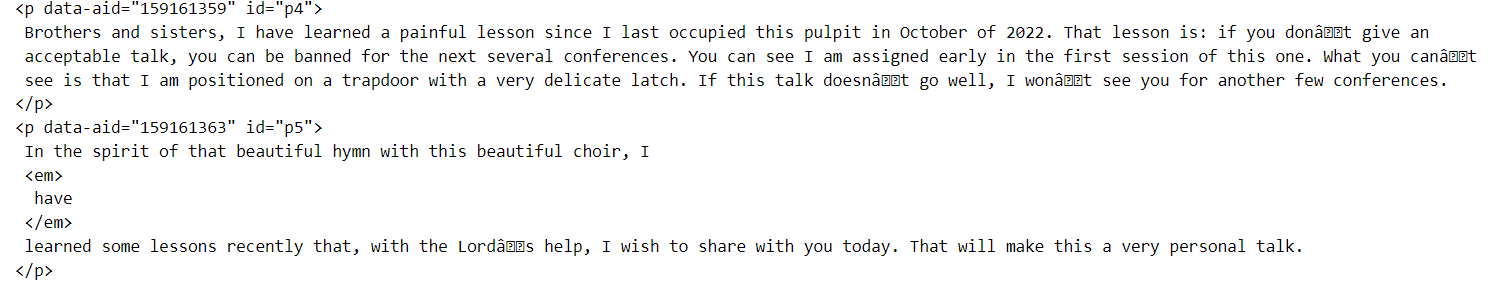

In the second paragraph of his talk, Elder Holland emphasizes the word *have*, and it adds at least 4 lines to the that paragraph in the "behind the scenes" html code, even if those extra lines don't actually display. The first extra line invokes the emphasis (`<em>`), the second only has the word "have", the third ends the emphasis (`</em>`), and the fourth picks up with the rest of the paragraph's text. 

My code needs to be updated to only count the lines as they are displayed on the webpage. 

In [40]:
# failed code - skip when running important stuff

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

def remove_emphasis_tags(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    for em in soup.find_all('em'):
        em.unwrap()  # Remove the <em> tags but keep the content
    text = soup.get_text()  # Get the text without tags
    return ' '.join(text.split())  # Remove extra newlines and spaces

def count_lines_and_paragraphs(text):
    lines = text.split('\n')  # Split text into lines
    paragraphs = text.split('\n\n')  # Split text into paragraphs based on double newlines
    return len(lines), len(paragraphs)

# Initialize the Chrome WebDriver
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

apr_2024_df['time'] = pd.NA
apr_2024_df['paragraphs'] = pd.NA
apr_2024_df['lines'] =pd.NA

for index,row in apr_2024_df.iterrows():
    title = row['Title']
    url = row['Link']

    driver.get(url)

    # Wait for the page to load completely
    driver.implicitly_wait(10)

    # Simulate clicking the play button using the class attribute
    try:
        # Locate the play button using its class attribute
        play_button = driver.find_element(By.CSS_SELECTOR, "button.sc-1g7hsbc-0.bCKkuP.sc-bvqtyr-3.eKGiZd")
        play_button.click()
        print(f"Clicked the play button for {title} to start the media.")
    except:
        print(f"Play button for {title} not found.")

    # Wait for the video element to be present in the DOM
    try:
        # Wait explicitly for the video to appear in the DOM
        video_element = WebDriverWait(driver, 20).until(
            EC.presence_of_element_located((By.TAG_NAME, 'video'))
        )
        print("Video element found in the DOM.")
    except:
        print("No video element found.")

    # Wait for a short period to allow the video to start loading
    time.sleep(5)

    # Attempt to retrieve the video duration using JavaScript
    try:
        video_duration = driver.execute_script("""
            let video = document.querySelector('video');
            if (video) {
                console.log('Video element is present, checking duration...');
                return video.duration;
            } else {
                let audio = document.querySelector('audio');
                if (audio) {
                    console.log('Audio element is present, checking duration...');
                    return audio.duration;
                }
            }
            return null;  // No media element found
        """)
        
        # Display the duration in seconds
        if video_duration:
            print(f"{title} duration: {video_duration:.2f} seconds")
            apr_2024_df.at[index,'time'] = video_duration
        else:
            print(f"No video or audio element found for {title}.")
            
    except Exception as e:
        print(f"Error retrieving video duration for {title}: {e}")

    paragraphs = driver.find_elements(By.CSS_SELECTOR, '.body-block p')
    apr_2024_df.at[index, 'paragraphs'] = len(paragraphs)
    print(f"Paragraph length of {title}: {len(paragraphs)} paragraphs.")

    try:
        body = driver.find_element(By.CLASS_NAME, 'body-block')
        html_content = body.get_attribute('outerHTML')  # Get the HTML content of the element
        text = remove_emphasis_tags(html_content)  # Remove emphasis tags and get the clean text
        
        # Count lines and paragraphs
        num_lines, num_paragraphs = count_lines_and_paragraphs(text)
        apr_2024_df.at[index, 'paragraphs'] = num_paragraphs
        apr_2024_df.at[index, 'lines'] = num_lines
        
        print(f"Paragraph length of {title}: {num_paragraphs} paragraphs.")
        print(f"Line length of {title}: {num_lines} lines.")
        
    except Exception as e:
        print(f"Error calculating lines and paragraphs for {title}: {e}")

# Close the browser
driver.quit()

Clicked the play button for Motions of a Hidden Fire to start the media.
Video element found in the DOM.
Motions of a Hidden Fire duration: 808.14 seconds
Paragraph length of Motions of a Hidden Fire: 21 paragraphs.
Paragraph length of Motions of a Hidden Fire: 1 paragraphs.
Line length of Motions of a Hidden Fire: 1 lines.
Clicked the play button for Put Ye On the Lord Jesus Christ to start the media.
Video element found in the DOM.
Put Ye On the Lord Jesus Christ duration: 716.25 seconds
Paragraph length of Put Ye On the Lord Jesus Christ: 23 paragraphs.
Paragraph length of Put Ye On the Lord Jesus Christ: 1 paragraphs.
Line length of Put Ye On the Lord Jesus Christ: 1 lines.
Clicked the play button for Pillars and Rays to start the media.
No video element found.
Pillars and Rays duration: 677.31 seconds
Paragraph length of Pillars and Rays: 37 paragraphs.
Paragraph length of Pillars and Rays: 1 paragraphs.
Line length of Pillars and Rays: 1 lines.
Clicked the play button for Covenan

KeyboardInterrupt: 

After trying a few "copy and paste" solutions from ChatGPT, none of which worked, I decided to take a different approach - trying to use the character limit per line to determine how many lines each paragraph could have. 

In [56]:
# failed code cell - skip when running important stuff

def count_lines(text, char_limit_per_line):
    # Remove extra newlines and spaces to get a cleaner text
    text = ' '.join(text.split())
    # Calculate the number of lines based on character limit
    num_lines = len(text) // char_limit_per_line
    if len(text) % char_limit_per_line:
        num_lines += 1
    return num_lines

# Initialize the Chrome WebDriver
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

apr_2024_df['time'] = pd.NA
apr_2024_df['paragraphs'] = pd.NA
apr_2024_df['lines'] = pd.NA

for index, row in apr_2024_df.iterrows():
    title = row['Title']
    url = row['Link']

    driver.get(url)

    # Wait for the page to load completely
    driver.implicitly_wait(10)

    # Simulate clicking the play button using the class attribute
    try:
        play_button = driver.find_element(By.CSS_SELECTOR, "button.sc-1g7hsbc-0.bCKkuP.sc-bvqtyr-3.eKGiZd")
        play_button.click()
        print(f"Clicked the play button for {title} to start the media.")
    except:
        print(f"Play button for {title} not found.")

    # Wait for the video element to be present in the DOM
    try:
        video_element = WebDriverWait(driver, 20).until(
            EC.presence_of_element_located((By.TAG_NAME, 'video'))
        )
        print("Video element found in the DOM.")
    except:
        print("No video element found.")

    # Wait for a short period to allow the video to start loading
    time.sleep(5)

    # Attempt to retrieve the video duration using JavaScript
    try:
        video_duration = driver.execute_script("""
            let video = document.querySelector('video');
            if (video) {
                console.log('Video element is present, checking duration...');
                return video.duration;
            } else {
                let audio = document.querySelector('audio');
                if (audio) {
                    console.log('Audio element is present, checking duration...');
                    return audio.duration;
                }
            }
            return null;  // No media element found
        """)
        
        if video_duration:
            print(f"{title} duration: {video_duration:.2f} seconds")
            apr_2024_df.at[index, 'time'] = video_duration
        else:
            print(f"No video or audio element found for {title}.")
            
    except Exception as e:
        print(f"Error retrieving video duration for {title}: {e}")

    try:
        paragraphs = driver.find_elements(By.CSS_SELECTOR, '.body-block p')
        apr_2024_df.at[index, 'paragraphs'] = len(paragraphs)
        print(f"Paragraph length of {title}: {len(paragraphs)} paragraphs.")

        body = driver.find_element(By.CLASS_NAME, 'body-block')
        html_content = body.get_attribute('outerHTML')  # Get the HTML content of the element
        
        text = remove_emphasis_tags(html_content)  # Remove emphasis tags and get the clean text
        
        # Estimate line length (adjust based on your content width)
        char_limit_per_line = 80  # Example character limit per line
        num_lines = count_lines(text, char_limit_per_line)
        
        apr_2024_df.at[index, 'lines'] = num_lines
        
        print(f"Line length of {title}: {num_lines} lines.")
        
    except Exception as e:
        print(f"Error calculating lines and paragraphs for {title}: {e}")

# Close the browser
driver.quit()

Clicked the play button for Motions of a Hidden Fire to start the media.
Video element found in the DOM.
Motions of a Hidden Fire duration: 808.14 seconds
Paragraph length of Motions of a Hidden Fire: 21 paragraphs.
Line length of Motions of a Hidden Fire: 105 lines.
Clicked the play button for Put Ye On the Lord Jesus Christ to start the media.
Video element found in the DOM.
Put Ye On the Lord Jesus Christ duration: 716.25 seconds
Paragraph length of Put Ye On the Lord Jesus Christ: 23 paragraphs.
Line length of Put Ye On the Lord Jesus Christ: 114 lines.
Clicked the play button for Pillars and Rays to start the media.
Video element found in the DOM.
Pillars and Rays duration: 677.31 seconds
Paragraph length of Pillars and Rays: 37 paragraphs.
Line length of Pillars and Rays: 111 lines.
Clicked the play button for Covenant Confidence through Jesus Christ to start the media.
Video element found in the DOM.


KeyboardInterrupt: 

However, I found that doing that resulted in line counts that were far under what I could count when I actually navigated to the webpage. 

After a few hours of failing to figure out why my line counts were so far off in my current code, I decided to try some previously used code to see if it gets the right line lengths. After navigating my webdriver to Elder Holland's talk, and using a previously created calculator, I determined that the previous one gets the correct number of lines. 

In [15]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

# Make sure to close any lingering driver sessions
driver.quit()

# Start a new session
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

# initializes a dataframe to store paragraph and line counts in
data_list = pd.DataFrame()
data_list['paragraph'] = pd.NA
data_list['lines'] = pd.NA

# navigates to Elder Holland's talk "Motions of a Hidden Fire"
driver.get(jrh_link)

# Find all elements containing the text
# Gets all the paragraph elements within the body block of the talk
paragraphs = driver.find_elements(By.CSS_SELECTOR, '.body-block p')

# Iterate over each paragraph element
for index, paragraph in enumerate(paragraphs, start=1):
    # Get the text of the element
    text = paragraph.text

    # Log paragraph number, since the paragraphs are not numbered. 
    paragraph_number = index

    # Get the bounding rectangle of the element
    rect = paragraph.rect

    # Calculate line height
    line_height_str = driver.execute_script("return window.getComputedStyle(arguments[0]).getPropertyValue('line-height');", paragraph)
    line_height_numeric = int(re.search(r'\d+', line_height_str).group())  # Extract numeric value from string

    # Calculate number of lines
    num_lines = rect['height'] // line_height_numeric

    # Append data dictionary to list
    data_list.at[index,'paragraph'] = paragraph_number
    data_list.at[index, 'lines'] = num_lines

driver.quit()

# print the newly populated dataframe
print(data_list)

# print the sum of the numbers of lines for each paragraph, giving the total line length of the talk
print(sum(data_list['lines']))

NameError: name 'jrh_link' is not defined

Paragraph 1 of his talk **does** have 8 lines on the webpage. Paragraph 2 **does** have 4 lines, and so on, and the whole talk **does** have 151 lines total. 

So, there's something about how my previous calculator calculated the lines that is not registering, but I can adapt my code to make it work. I can turn the above into a function to get the number of lines, and incorporate that function into my code. 

The function below (`get_total_lines(url)`) was designed specifically to run using an already active webdriver to gather paragraph and line length information about a general conference talk.
* First, it uses a webdriver to navigate to a url and then finds the paragraphs within a body block, and gets the size of the rectangles within which each of those paragraphs are assigned to appear. 
* Then, calculates the height of each line, saves that number as an integer, and calculates how many of those lines would fit into the assigned rectangle. 
* Then, it adds the paragraph number and the number of lines in that paragraph to the previously created dataframe.
* Finally, it calculates and returns the total number of lines in the talk by getting the sum of all paragraph lengths in lines. 

In [17]:
# Begin defining function
def get_total_lines(url):
    """
    This function was designed specifically to run using an already active webdriver to gather paragraph and line length information about a general conference talk.
    First, it uses a webdriver to navigate to a url and then finds the paragraphs within a body block, and gets the size of the rectangles within which each of those paragraphs are assigned to appear. 
    Then, calculates the height of each line, saves that number as an integer, and calculates how many of those lines would fit into the assigned rectangle. 
    Then, it adds the paragraph number and the number of lines in that paragraph to the previously created dataframe.
    Finally, it calculates and returns the total number of lines in the talk by getting the sum of all paragraph lengths in lines. 
    """
    # initialize empty dataframe "data_list", with columns "paragraph" and "lines" being initially populated with NA values
    data_list = pd.DataFrame()
    data_list['paragraph'] = pd.NA
    data_list['lines'] = pd.NA

    # Find all elements containing the text
    paragraphs = driver.find_elements(By.CSS_SELECTOR, '.body-block p')

    # Iterate over each paragraph element
    for index, paragraph in enumerate(paragraphs, start=1):
        # Log paragraph number, since the paragraphs are not numbered. 
        paragraph_number = index

        # Get the bounding rectangle of the element
        rect = paragraph.rect

        # Calculate line height
        line_height_str = driver.execute_script("return window.getComputedStyle(arguments[0]).getPropertyValue('line-height');", paragraph)
        line_height_numeric = int(re.search(r'\d+', line_height_str).group())  # Extract numeric value from string

        # Calculate number of lines
        num_lines = rect['height'] // line_height_numeric

        # Append data dictionary to list
        data_list.at[index,'paragraph'] = paragraph_number
        data_list.at[index, 'lines'] = num_lines

        total_lines = sum(data_list['lines'])
    
    return total_lines

After defining my function, I could easily incorporate it into my code. It can be found by looking for the following snippet of code in the cell below:

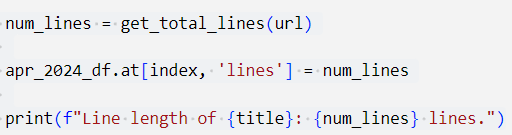

I also added to the cell below a snippet of code to grab the Author's role. 

In [18]:
# Initialize the Chrome WebDriver
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

# Initialize columns in the dataframe with NA values to later be filled
apr_2024_df['time'] = pd.NA
apr_2024_df['paragraphs'] = pd.NA
apr_2024_df['lines'] = pd.NA
apr_2024_df['role'] = pd.NA

# iterate the following over each row in the apr_2024_df dataframe
for index, row in apr_2024_df.iterrows():
    # for each row, when the function calls for title, url, and author it is looking for the Title, Link, and Author columns in that row, respectively
    title = row['Title']
    url = row['Link']
    author = row['Author']

    # run the driver, navigating to the linked page in the row currently being worked on
    driver.get(url)

    # Wait for the page to load completely
    driver.implicitly_wait(10)

    # Simulate clicking the play button using the class attribute
    try:
        play_button = driver.find_element(By.CSS_SELECTOR, "button.sc-1g7hsbc-0.bCKkuP.sc-bvqtyr-3.eKGiZd")
        play_button.click()
        print(f"Clicked the play button for {title} to start the media.")
    except:
        print(f"Play button for {title} not found.")

    # Wait for the video element to be present in the DOM
    try:
        video_element = WebDriverWait(driver, 20).until(
            EC.presence_of_element_located((By.TAG_NAME, 'video'))
        )
        print("Video element found in the DOM.")
    except:
        print("No video element found.")

    # Wait for a short period to allow the video to start loading
    time.sleep(5)

    # Attempt to retrieve the video duration using JavaScript
    try:
        video_duration = driver.execute_script("""
            let video = document.querySelector('video');
            if (video) {
                console.log('Video element is present, checking duration...');
                return video.duration;
            } else {
                let audio = document.querySelector('audio');
                if (audio) {
                    console.log('Audio element is present, checking duration...');
                    return audio.duration;
                }
            }
            return null;  // No media element found
        """)
        
        # if video_duration exists
        if video_duration:
            # print a message saying how long the talk is in seconds
            print(f"{title} duration: {video_duration:.2f} seconds")
            # save the duration into the dataframe in the same row
            apr_2024_df.at[index, 'time'] = video_duration
        # otherwise, print a message saying no video or audio element was found for the talk
        else:
            print(f"No video or audio element found for {title}.")
    
    # If there is an error, say there was an error and what it was, and try to get the next piece of information       
    except Exception as e:
        print(f"Error retrieving video duration for {title}: {e}")

    # attempt to find the body block
    try:
        paragraphs = driver.find_elements(By.CSS_SELECTOR, '.body-block p')
        # if body block is found, find the number of paragraphs, and save that number to the dataframe in the same row
        apr_2024_df.at[index, 'paragraphs'] = len(paragraphs)
        # print a message giving the length of the talk in paragraphs
        print(f"Paragraph length of {title}: {len(paragraphs)} paragraphs.")

        # Use the get_total_lines function to get the total number of lines in the talk
        num_lines = get_total_lines(url)
        
        # save the number of lines to the dataframe in the same row
        apr_2024_df.at[index, 'lines'] = num_lines
        
        # print a message telling the number of lines in the talk
        print(f"Line length of {title}: {num_lines} lines.")

    # if there is an error or a problem, print a message saying what the problem was, and try to get the next piece of information 
    except Exception as e:
        print(f"Error calculating lines and paragraphs for {title}: {e}")
    
    # try to find the author role
    try:
        role = driver.find_element(By.CLASS_NAME, 'author-role')
        # if there is one, save it to the dataframe in the same row
        apr_2024_df.at[index, 'role'] = role.text
        # print a message displaying the role of the author
        print(f"Role of {author}: {role.text}")
    # if there is an error or a problem, print a message saying what the problem was and then move onto the next row
    except Exception as e:
        print(f"Error retrieving role for {author}: {e}")

# Close the browser after all rows have been iterated through
driver.quit()

Clicked the play button for Motions of a Hidden Fire to start the media.
Video element found in the DOM.
Motions of a Hidden Fire duration: 808.14 seconds
Paragraph length of Motions of a Hidden Fire: 21 paragraphs.
Line length of Motions of a Hidden Fire: 151 lines.
Role of Jeffrey R. Holland: Acting President of the Quorum of the Twelve Apostles
Clicked the play button for Put Ye On the Lord Jesus Christ to start the media.
Video element found in the DOM.
Put Ye On the Lord Jesus Christ duration: 716.25 seconds
Paragraph length of Put Ye On the Lord Jesus Christ: 23 paragraphs.
Line length of Put Ye On the Lord Jesus Christ: 164 lines.
Role of J. Anette Dennis: First Counselor in the Relief Society General Presidency
Clicked the play button for Pillars and Rays to start the media.
Video element found in the DOM.
Pillars and Rays duration: 677.31 seconds
Paragraph length of Pillars and Rays: 37 paragraphs.
Line length of Pillars and Rays: 164 lines.
Role of Alexander Dushku: Of the Se

Wonderful! I got the code to register the correct number of lines! Now I have a data frame that shows the Author, Title, Description, Link, Length in Time, Paragraphs, and Lines, and the role of the Author for each talk. 

In [19]:
# display the dataframe with the gathered information
apr_2024_df

,Author,Title,Description,Link,time,paragraphs,lines,role
3,Jeffrey R. Holland,Motions of a Hidden Fire,President Holland teaches about the power of p...,https://www.churchofjesuschrist.org/study/gene...,808.14,21,151,Acting President of the Quorum of the Twelve A...
4,J. Anette Dennis,Put Ye On the Lord Jesus Christ,"Sister Dennis teaches about the importance, po...",https://www.churchofjesuschrist.org/study/gene...,716.248,23,164,First Counselor in the Relief Society General ...
5,Alexander Dushku,Pillars and Rays,Elder Dushku teaches us that spectacular spiri...,https://www.churchofjesuschrist.org/study/gene...,677.309,37,164,Of the Seventy
6,Ulisses Soares,Covenant Confidence through Jesus Christ,Elder Soares teaches about the importance of l...,https://www.churchofjesuschrist.org/study/gene...,868.5,19,181,Of the Quorum of the Twelve Apostles
7,Jack N. Gerard,Integrity: A Christlike Attribute,Elder Gerard teaches that living a life of int...,https://www.churchofjesuschrist.org/study/gene...,684.717,22,137,Of the Seventy
8,Henry B. Eyring,All Will Be Well Because of Temple Covenants,President Eyring teaches that as we make and k...,https://www.churchofjesuschrist.org/study/gene...,992.524,30,169,Second Counselor in the First Presidency
10,David A. Bednar,"“Be Still, and Know That I Am God”","Elder Bednar teaches that when we are “still,”...",https://www.churchofjesuschrist.org/study/gene...,884.55,29,179,Of the Quorum of the Twelve Apostles
11,Massimo De Feo,Rise! He Calleth Thee,Elder De Feo teaches that blessings come when ...,https://www.churchofjesuschrist.org/study/gene...,681.7809,51,157,Of the Seventy
12,Brent H. Nielson,A Record of What I Have Both Seen and Heard,Elder Nielson describes the growth of the Chur...,https://www.churchofjesuschrist.org/study/gene...,709.1079,25,176,Of the Presidency of the Seventy
13,Jose L. Alonso,Jesus Christ at the Center of Our Lives,Elder Alonso testifies that as we place Jesus ...,https://www.churchofjesuschrist.org/study/gene...,697.029,21,146,Of the Seventy


In [24]:
# get the column names for easy copying and pasting
apr_2024_df.columns

Index(['Author', 'role', 'Title', 'Description', 'Link', 'time', 'paragraphs',
       'lines'],
      dtype='object')

In [20]:
# establish the order of the columns
columns = ['Author', 'role','Title', 'Description', 'Link', 'time', 'paragraphs', 'lines']
# save the dataframe with the columns in that order
apr_2024_df = apr_2024_df[columns]
# display the reorganized dataframe
apr_2024_df

,Author,role,Title,Description,Link,time,paragraphs,lines
3,Jeffrey R. Holland,Acting President of the Quorum of the Twelve A...,Motions of a Hidden Fire,President Holland teaches about the power of p...,https://www.churchofjesuschrist.org/study/gene...,808.14,21,151
4,J. Anette Dennis,First Counselor in the Relief Society General ...,Put Ye On the Lord Jesus Christ,"Sister Dennis teaches about the importance, po...",https://www.churchofjesuschrist.org/study/gene...,716.248,23,164
5,Alexander Dushku,Of the Seventy,Pillars and Rays,Elder Dushku teaches us that spectacular spiri...,https://www.churchofjesuschrist.org/study/gene...,677.309,37,164
6,Ulisses Soares,Of the Quorum of the Twelve Apostles,Covenant Confidence through Jesus Christ,Elder Soares teaches about the importance of l...,https://www.churchofjesuschrist.org/study/gene...,868.5,19,181
7,Jack N. Gerard,Of the Seventy,Integrity: A Christlike Attribute,Elder Gerard teaches that living a life of int...,https://www.churchofjesuschrist.org/study/gene...,684.717,22,137
8,Henry B. Eyring,Second Counselor in the First Presidency,All Will Be Well Because of Temple Covenants,President Eyring teaches that as we make and k...,https://www.churchofjesuschrist.org/study/gene...,992.524,30,169
10,David A. Bednar,Of the Quorum of the Twelve Apostles,"“Be Still, and Know That I Am God”","Elder Bednar teaches that when we are “still,”...",https://www.churchofjesuschrist.org/study/gene...,884.55,29,179
11,Massimo De Feo,Of the Seventy,Rise! He Calleth Thee,Elder De Feo teaches that blessings come when ...,https://www.churchofjesuschrist.org/study/gene...,681.7809,51,157
12,Brent H. Nielson,Of the Presidency of the Seventy,A Record of What I Have Both Seen and Heard,Elder Nielson describes the growth of the Chur...,https://www.churchofjesuschrist.org/study/gene...,709.1079,25,176
13,Jose L. Alonso,Of the Seventy,Jesus Christ at the Center of Our Lives,Elder Alonso testifies that as we place Jesus ...,https://www.churchofjesuschrist.org/study/gene...,697.029,21,146


In [21]:
# converts all numeric columns to integers for easier use later
apr_2024_df['time'] = apr_2024_df['time'].astype(int).round(0)
apr_2024_df['paragraphs'] = apr_2024_df['paragraphs'].astype(int)
apr_2024_df['lines'] = apr_2024_df['lines'].astype(int)

Having gotten all of that information, I now want to do something a little easier and less webscraping-y. So, I'll get an abbreviated role code and a primary key made up for each of these talks!

Starting with the role code abbreviation, I needed to create copy the author role column and then write a replacement dictionary. I then used that replacement dictionary to replace certain words and phrases with better, less bulky abbreviations. 

In [28]:
# copies the role column onto a newly created role_code column
apr_2024_df['role_code'] = apr_2024_df['role']

# defines what phrases and such should be replaced with what
pk_rep_dict = {
    'Of the': '',
    'in the': '',
    'Quorum of the': '',
    'Acting President':'',
    'President':'prophet',
    'First Presidency':'1p',
    'Presidency':'',
    'Twelve Apostles':'q12',
    'First Counselor':'',
    'Second Counselor':'',
    'Relief Society General':'rs',
    'Sunday School General prophet':'ss',
    'Primary General prophet':'pri',
    'Seventy':'q70',
    'Young Men General':'ym',
    'Young Women General':'yw',
    'of The Church of Jesus Christ of Latter-day Saints':'',
    'of the ': '',
    "  ":"_",
    " ":"_",
}

# applies the replacement
for words, replacement in pk_rep_dict.items():
    apr_2024_df['role_code'] = apr_2024_df['role_code'].str.replace(words, replacement).str.strip()

# defines new column order
columns = ['Author', 'role','role_code','Title', 'Description', 'Link', 'time', 'paragraphs', 'lines']
# applies new column order
apr_2024_df = apr_2024_df[columns]
# displays newly organized dataframe
apr_2024_df

,Author,role,role_code,Title,Description,Link,time,paragraphs,lines
3,Jeffrey R. Holland,Acting President of the Quorum of the Twelve A...,q12,Motions of a Hidden Fire,President Holland teaches about the power of p...,https://www.churchofjesuschrist.org/study/gene...,808,21,151
4,J. Anette Dennis,First Counselor in the Relief Society General ...,rs,Put Ye On the Lord Jesus Christ,"Sister Dennis teaches about the importance, po...",https://www.churchofjesuschrist.org/study/gene...,716,23,164
5,Alexander Dushku,Of the Seventy,q70,Pillars and Rays,Elder Dushku teaches us that spectacular spiri...,https://www.churchofjesuschrist.org/study/gene...,677,37,164
6,Ulisses Soares,Of the Quorum of the Twelve Apostles,q12,Covenant Confidence through Jesus Christ,Elder Soares teaches about the importance of l...,https://www.churchofjesuschrist.org/study/gene...,868,19,181
7,Jack N. Gerard,Of the Seventy,q70,Integrity: A Christlike Attribute,Elder Gerard teaches that living a life of int...,https://www.churchofjesuschrist.org/study/gene...,684,22,137
8,Henry B. Eyring,Second Counselor in the First Presidency,1p,All Will Be Well Because of Temple Covenants,President Eyring teaches that as we make and k...,https://www.churchofjesuschrist.org/study/gene...,992,30,169
10,David A. Bednar,Of the Quorum of the Twelve Apostles,q12,"“Be Still, and Know That I Am God”","Elder Bednar teaches that when we are “still,”...",https://www.churchofjesuschrist.org/study/gene...,884,29,179
11,Massimo De Feo,Of the Seventy,q70,Rise! He Calleth Thee,Elder De Feo teaches that blessings come when ...,https://www.churchofjesuschrist.org/study/gene...,681,51,157
12,Brent H. Nielson,Of the Presidency of the Seventy,q70,A Record of What I Have Both Seen and Heard,Elder Nielson describes the growth of the Chur...,https://www.churchofjesuschrist.org/study/gene...,709,25,176
13,Jose L. Alonso,Of the Seventy,q70,Jesus Christ at the Center of Our Lives,Elder Alonso testifies that as we place Jesus ...,https://www.churchofjesuschrist.org/study/gene...,697,21,146


After getting the role abbreviations, which will be used later for weighting each talk (which will impact my calculator later), I needed to get the initials of each speaker. I did that by defining a code that breaks each author string into parts on the spaces (so Russell M. Nelson becomes three parts - Russell, M., and Nelson), then takes the first (or 0th) character in the string (because python starts counting from 0), lower cases each, and saves them in an object called initials. The function the returns the joined initials. The full function turns "Russell M. Nelson" to "rmn". 

I then ran the function to create a new row, "initials", and then created a new row, "pk", which just takes the initials and adds "_apr24" to the end of it to create a primary key that identifies the speaker and the conference at which they spoke. 

I thought about trying to incorporate the role of the speaker into the primary key, but I realized that the likelihood of two talks having the same primary key is less than 
0.00006% (because they'd have to have all three of the same initials AND be speaking in the same conference), so I don't think it's necessary. 

In [29]:
# Function to get initials
def get_initials(full_name):
    parts = full_name.split()
    initials = [part[0].lower() for part in parts]
    return ''.join(initials)

# Create a new column with initials
apr_2024_df['initials'] = apr_2024_df['Author'].apply(get_initials)

apr_2024_df['pk'] = (apr_2024_df['initials'] + "_apr24")
apr_2024_df

C:\Users\bfran\AppData\Local\Temp\ipykernel_14020\524590323.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apr_2024_df['initials'] = apr_2024_df['Author'].apply(get_initials)


,Author,role,role_code,Title,Description,Link,time,paragraphs,lines,initials,pk
3,Jeffrey R. Holland,Acting President of the Quorum of the Twelve A...,q12,Motions of a Hidden Fire,President Holland teaches about the power of p...,https://www.churchofjesuschrist.org/study/gene...,808,21,151,jrh,jrh_apr24
4,J. Anette Dennis,First Counselor in the Relief Society General ...,rs,Put Ye On the Lord Jesus Christ,"Sister Dennis teaches about the importance, po...",https://www.churchofjesuschrist.org/study/gene...,716,23,164,jad,jad_apr24
5,Alexander Dushku,Of the Seventy,q70,Pillars and Rays,Elder Dushku teaches us that spectacular spiri...,https://www.churchofjesuschrist.org/study/gene...,677,37,164,ad,ad_apr24
6,Ulisses Soares,Of the Quorum of the Twelve Apostles,q12,Covenant Confidence through Jesus Christ,Elder Soares teaches about the importance of l...,https://www.churchofjesuschrist.org/study/gene...,868,19,181,us,us_apr24
7,Jack N. Gerard,Of the Seventy,q70,Integrity: A Christlike Attribute,Elder Gerard teaches that living a life of int...,https://www.churchofjesuschrist.org/study/gene...,684,22,137,jng,jng_apr24
8,Henry B. Eyring,Second Counselor in the First Presidency,1p,All Will Be Well Because of Temple Covenants,President Eyring teaches that as we make and k...,https://www.churchofjesuschrist.org/study/gene...,992,30,169,hbe,hbe_apr24
10,David A. Bednar,Of the Quorum of the Twelve Apostles,q12,"“Be Still, and Know That I Am God”","Elder Bednar teaches that when we are “still,”...",https://www.churchofjesuschrist.org/study/gene...,884,29,179,dab,dab_apr24
11,Massimo De Feo,Of the Seventy,q70,Rise! He Calleth Thee,Elder De Feo teaches that blessings come when ...,https://www.churchofjesuschrist.org/study/gene...,681,51,157,mdf,mdf_apr24
12,Brent H. Nielson,Of the Presidency of the Seventy,q70,A Record of What I Have Both Seen and Heard,Elder Nielson describes the growth of the Chur...,https://www.churchofjesuschrist.org/study/gene...,709,25,176,bhn,bhn_apr24
13,Jose L. Alonso,Of the Seventy,q70,Jesus Christ at the Center of Our Lives,Elder Alonso testifies that as we place Jesus ...,https://www.churchofjesuschrist.org/study/gene...,697,21,146,jla,jla_apr24


In [29]:
# gets the column names for easy copying and pasting
apr_2024_df.columns

Index(['Author', 'role', 'role_code', 'Title', 'Description', 'Link', 'time',
       'paragraphs', 'lines', 'initials', 'pk'],
      dtype='object')

In [30]:
# defines the new column order
columns = ['pk','Author', 'role', 'role_code', 'Title', 'Description', 'Link', 'time','paragraphs', 'lines']

# reorganizes columns
apr_2024_df = apr_2024_df[columns]

After getting primary keys for each talk, I wanted to wrap up the day by quickly assigning a "weight" to each talk. This weight will be used to figure out how much time I put into each talk. Basically, I want to give each talk given by an Apostle 1 more day (per read through) than I do to talks given by other organizations, and I want to give each talk given by the President of the Church 1 more day (per read through) than I do to talks given by the rest of the Apostles. 

In [31]:
# initialize a 'weight' column populated with null values
apr_2024_df['day_weight'] = pd.NA

# fill each 'weight' value with a 1, 0, or -1 based on the speaker
for index, row in apr_2024_df.iterrows():
    # the president of the Church (prophet) gets a 1
    if row['role_code'] == 'prophet':
        apr_2024_df.at[index, 'day_weight'] = 1
    # the apostles and first presidency counselors get a 0
    if row['role_code'] == '1p' or row['role_code'] == 'q12':
        apr_2024_df.at[index, 'day_weight'] = 0
    # everyone else gets a -1
    else:
        apr_2024_df.at[index, 'day_weight'] = -1

In [32]:
# establish new, better column order
columns = ['pk','Author', 'role', 'role_code', 'day_weight','Title', 'Description', 'Link', 'time',
       'paragraphs', 'lines']

# apply new column order
apr_2024_df = apr_2024_df[columns]

# display updated dataframe
apr_2024_df

,pk,Author,role,role_code,day_weight,Title,Description,Link,time,paragraphs,lines
3,jrh_apr24,Jeffrey R. Holland,Acting President of the Quorum of the Twelve A...,q12,0,Motions of a Hidden Fire,President Holland teaches about the power of p...,https://www.churchofjesuschrist.org/study/gene...,808,21,151
4,jad_apr24,J. Anette Dennis,First Counselor in the Relief Society General ...,rs,-1,Put Ye On the Lord Jesus Christ,"Sister Dennis teaches about the importance, po...",https://www.churchofjesuschrist.org/study/gene...,716,23,164
5,ad_apr24,Alexander Dushku,Of the Seventy,q70,-1,Pillars and Rays,Elder Dushku teaches us that spectacular spiri...,https://www.churchofjesuschrist.org/study/gene...,677,37,164
6,us_apr24,Ulisses Soares,Of the Quorum of the Twelve Apostles,q12,0,Covenant Confidence through Jesus Christ,Elder Soares teaches about the importance of l...,https://www.churchofjesuschrist.org/study/gene...,868,19,181
7,jng_apr24,Jack N. Gerard,Of the Seventy,q70,-1,Integrity: A Christlike Attribute,Elder Gerard teaches that living a life of int...,https://www.churchofjesuschrist.org/study/gene...,684,22,137
8,hbe_apr24,Henry B. Eyring,Second Counselor in the First Presidency,1p,0,All Will Be Well Because of Temple Covenants,President Eyring teaches that as we make and k...,https://www.churchofjesuschrist.org/study/gene...,992,30,169
10,dab_apr24,David A. Bednar,Of the Quorum of the Twelve Apostles,q12,0,"“Be Still, and Know That I Am God”","Elder Bednar teaches that when we are “still,”...",https://www.churchofjesuschrist.org/study/gene...,884,29,179
11,mdf_apr24,Massimo De Feo,Of the Seventy,q70,-1,Rise! He Calleth Thee,Elder De Feo teaches that blessings come when ...,https://www.churchofjesuschrist.org/study/gene...,681,51,157
12,bhn_apr24,Brent H. Nielson,Of the Presidency of the Seventy,q70,-1,A Record of What I Have Both Seen and Heard,Elder Nielson describes the growth of the Chur...,https://www.churchofjesuschrist.org/study/gene...,709,25,176
13,jla_apr24,Jose L. Alonso,Of the Seventy,q70,-1,Jesus Christ at the Center of Our Lives,Elder Alonso testifies that as we place Jesus ...,https://www.churchofjesuschrist.org/study/gene...,697,21,146


### 16 Sep 2024

Having gotten that dataframe (with primary keys, authors, roles and role codes, titles, descriptions, links, and lengths in seconds, paragraphs, and lines) set up, I was ready to quickly gather the paragraph numbers, text, and line length for each paragraph of each talk. I'll be saving these like I saved the chapters, verses, and lengths of the scriptures. 

I'll be gathering the text of each paragraph of the talk so that I can actually physically print each one with a labelled paragraph number so I don't have to label them myself after printing them. 

Because I actually already scraped the length of each paragraph above (in order to add them all up to get the total line length of each talk), I know I can get that to work with relative ease, especially when I consider that I just adapted that from the function I already had written in the Book of Mormon Webscraping notebook, which I can easily use here.

In [66]:
def get_talks(talk_link):
    """
    This function finds the description and text of a talk found at the talk link, numbers each paragraph of that talk and gets the text and length in lines of each paragraph. It returns as a dataframe all this information about each talk. 
    """
    # Import needed packages
    import pandas as pd
    import requests
    import os
    import time
    from selenium import webdriver
    from selenium.webdriver.chrome.service import Service
    from selenium.webdriver.common.by import By
    from selenium.webdriver.chrome.options import Options
    import re

    # Define the path to the chromedriver executable
    chrome_driver_dir = rD:\\Faith and Religion Stuff\\Come, Follow Me\\chromedriver-win64
    chrome_driver_path = os.path.join(chrome_driver_dir, 'chromedriver.exe')

    # Set up the headless browser options
    chrome_options = Options()
    chrome_options.add_argument("--headless")
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--window-size=1920x1080")

    # Set up the Chrome service
    service = Service(chrome_driver_path)    
    
    # Initialize the Chrome WebDriver
    driver = webdriver.Chrome(service=service, options=chrome_options)

    # Run the driver
    driver.get(talk_link)

    # Initialize a list to store data dictionaries
    data_list = []

    # Try to get the description - the summary blurb about the video, talk, or report
    try:
        # Finds and stores the description (kicker) element (the title of the video, talk, or report)
        description_element = driver.find_element(By.CSS_SELECTOR,'p.kicker')
        # Saves the stored description as text
        description = description_element.text

        # set paragraph number for description as 0
        paragraph_number = 0
        
        # Get the bounding rectangle of the element
        rect = description_element.rect

        # Calculate line height
        line_height_str = driver.execute_script("return window.getComputedStyle(arguments[0]).getPropertyValue('line-height');", description_element)
        line_height_numeric = int(re.search(r'\d+', line_height_str).group())  # Extract numeric value from string

        # Calculate number of lines
        num_lines = rect['height'] // line_height_numeric

        # add text of and information about description to the data_list dictionary
        data_list.append({
            'paragraph_number': paragraph_number,
            'num_lines': num_lines,
            'text': description
        })

    # If there is no description, save it as None - THIS SHOULD NEVER BE THE CASE
    except:
        description = None

    # Find all elements containing the text
    paragraphs = driver.find_elements(By.CSS_SELECTOR, '.body-block p')

    # Iterate over each paragraph element
    for index, paragraph in enumerate(paragraphs, start=1):
        # Get the text of the element
        text = paragraph.text

        # Log paragraph number, since the paragraphs are not numbered. 
        paragraph_number = index

        # Get the bounding rectangle of the element
        rect = paragraph.rect

        # Calculate line height
        line_height_str = driver.execute_script("return window.getComputedStyle(arguments[0]).getPropertyValue('line-height');", paragraph)
        line_height_numeric = int(re.search(r'\d+', line_height_str).group())  # Extract numeric value from string

        # Calculate number of lines
        num_lines = rect['height'] // line_height_numeric

        # Append data dictionary to list
        data_list.append({
            'paragraph_number': paragraph_number,
            'num_lines': num_lines,
            'text': text
        })

    # Convert list of dictionaries to DataFrame
    df = pd.DataFrame(data_list)

    # Close the browser
    driver.quit()
    return df

Getting this working took longer than I expected, mostly because I decided that I also wanted to get the description into it, too. The main issue I ran into with that is that I *was* having the driver look for a `p.description` element, when actually I needed to be looking for a `p.kicker` element. I realized that was the issue after making minor changes here and there in the code to no avail until I inspected the html of Elder Holland's talk to be sure I was looking for the right element. 

Since I demonstrate in the cell below that the function works, I can now apply it in generally the same way I applied past functions to the scriptures. 

In [67]:
get_talks(jrh_link)

,paragraph_number,num_lines,text
0,0,2,God hears every prayer we offer and responds t...
1,1,8,"Brothers and sisters, I have learned a painful..."
2,2,4,In the spirit of that beautiful hymn with this...
3,3,12,The most personal and painful of all these rec...
4,4,4,Another experience began 48 hours after my wif...
5,5,7,Virtually all my experience in the hospital du...
6,6,3,I couldn’t help but feel I was receiving my ow...
7,7,2,“Thou shalt bear record of my name … [and] sen...
8,8,3,“… Morning by morning; and day after day let t...
9,9,1,"“Arise[,] … take up your cross, [and] follow me.”"


In [33]:
apr_2024_df

,pk,Author,role,role_code,day_weight,Title,Description,Link,time,paragraphs,lines
3,jrh_apr24,Jeffrey R. Holland,Acting President of the Quorum of the Twelve A...,q12,0,Motions of a Hidden Fire,President Holland teaches about the power of p...,https://www.churchofjesuschrist.org/study/gene...,808,21,151
4,jad_apr24,J. Anette Dennis,First Counselor in the Relief Society General ...,rs,-1,Put Ye On the Lord Jesus Christ,"Sister Dennis teaches about the importance, po...",https://www.churchofjesuschrist.org/study/gene...,716,23,164
5,ad_apr24,Alexander Dushku,Of the Seventy,q70,-1,Pillars and Rays,Elder Dushku teaches us that spectacular spiri...,https://www.churchofjesuschrist.org/study/gene...,677,37,164
6,us_apr24,Ulisses Soares,Of the Quorum of the Twelve Apostles,q12,0,Covenant Confidence through Jesus Christ,Elder Soares teaches about the importance of l...,https://www.churchofjesuschrist.org/study/gene...,868,19,181
7,jng_apr24,Jack N. Gerard,Of the Seventy,q70,-1,Integrity: A Christlike Attribute,Elder Gerard teaches that living a life of int...,https://www.churchofjesuschrist.org/study/gene...,684,22,137
8,hbe_apr24,Henry B. Eyring,Second Counselor in the First Presidency,1p,0,All Will Be Well Because of Temple Covenants,President Eyring teaches that as we make and k...,https://www.churchofjesuschrist.org/study/gene...,992,30,169
10,dab_apr24,David A. Bednar,Of the Quorum of the Twelve Apostles,q12,0,"“Be Still, and Know That I Am God”","Elder Bednar teaches that when we are “still,”...",https://www.churchofjesuschrist.org/study/gene...,884,29,179
11,mdf_apr24,Massimo De Feo,Of the Seventy,q70,-1,Rise! He Calleth Thee,Elder De Feo teaches that blessings come when ...,https://www.churchofjesuschrist.org/study/gene...,681,51,157
12,bhn_apr24,Brent H. Nielson,Of the Presidency of the Seventy,q70,-1,A Record of What I Have Both Seen and Heard,Elder Nielson describes the growth of the Chur...,https://www.churchofjesuschrist.org/study/gene...,709,25,176
13,jla_apr24,Jose L. Alonso,Of the Seventy,q70,-1,Jesus Christ at the Center of Our Lives,Elder Alonso testifies that as we place Jesus ...,https://www.churchofjesuschrist.org/study/gene...,697,21,146


In [69]:
# Define directory path for saving CSV files
dir_path = r'D:\\Faith and Religion Stuff\\Come, Follow Me Breakdowns\\April 2024 GC Talks'

for index, row in apr_2024_df.iterrows():
    title = row['Title']
    link = row['Link']
    foreign_key = row['pk']

    talk_lines_df = get_talks(link)

    if talk_lines_df is not None and not talk_lines_df.empty:
        talk_lines_df['foreign_key'] = foreign_key

        talk_lines_df['pk'] = talk_lines_df.apply(lambda x:f"{foreign_key}_{x.get('paragraph_number')}", axis=1)

        columns_to_keep = ['foreign_key','pk']
        columns_to_keep.append('paragraph_number')
        columns_to_keep.append('text')
        columns_to_keep.append('num_lines')

        talk_lines_df = talk_lines_df[columns_to_keep]

        csv_filename = f'{foreign_key}_lines.csv'
        full_path = os.path.join(dir_path,csv_filename)

        print(f'Saving to: {full_path}')

        talk_lines_df.to_csv(full_path, index = False)

        print(f'CSV file for "{title}" saved successfully as {csv_filename}.')
    
    else:
        print(f'No data found for "{title}", skipping CSV creation.')

Saving to: D:\\Faith and Religion Stuff\\Come, Follow Me Breakdowns\\April 2024 GC Talks\jrh_apr24_lines.csv
CSV file for "Motions of a Hidden Fire" saved successfully as jrh_apr24_lines.csv.
Saving to: D:\\Faith and Religion Stuff\\Come, Follow Me Breakdowns\\April 2024 GC Talks\jad_apr24_lines.csv
CSV file for "Put Ye On the Lord Jesus Christ" saved successfully as jad_apr24_lines.csv.
Saving to: D:\\Faith and Religion Stuff\\Come, Follow Me Breakdowns\\April 2024 GC Talks\ad_apr24_lines.csv
CSV file for "Pillars and Rays" saved successfully as ad_apr24_lines.csv.
Saving to: D:\\Faith and Religion Stuff\\Come, Follow Me Breakdowns\\April 2024 GC Talks\us_apr24_lines.csv
CSV file for "Covenant Confidence through Jesus Christ" saved successfully as us_apr24_lines.csv.
Saving to: D:\\Faith and Religion Stuff\\Come, Follow Me Breakdowns\\April 2024 GC Talks\jng_apr24_lines.csv
CSV file for "Integrity: A Christlike Attribute" saved successfully as jng_apr24_lines.csv.
Saving to: D:\\Faith

Great! Now that those have been gathered and downloaded as CSV files, I can proceed with building the actual schedule calculator tomorrow. 

### 27 Sep 2024

When I started to get to work on my calculator, I realized that I'd need the dataframe I made with the talks, primary keys, descriptions, total lengths, etc., saved as a csv file so I could access it from another notebook. The cell below does that. 

In [34]:
path = 'D:\Faith and Religion Stuff\Come, Follow Me'
name = 'apr_2024_gc_info.csv'
full_path = os.path.join(path, name)
apr_2024_df.to_csv(full_path,index = False)